## SETUP

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import load_model
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import os
# import gdown
# from zipfile import ZipFile
import pandas as pd

# import imageio
# from tensorflow_docs.vis import embed

## PARAMETERS

In [69]:
image_size = 256
generator_input = 2
batch_size = 32
folder = 'BasicGAN_gen/10Kimg/setting 1/'

## IMPORT

In [70]:
dataset = keras.preprocessing.image_dataset_from_directory(
   "images_proc", label_mode=None, image_size=(image_size, image_size), 
   batch_size=batch_size, crop_to_aspect_ratio=True, shuffle=True
)
dataset = dataset.map(lambda x: x / 255.0)

Found 10128 files belonging to 1 classes.


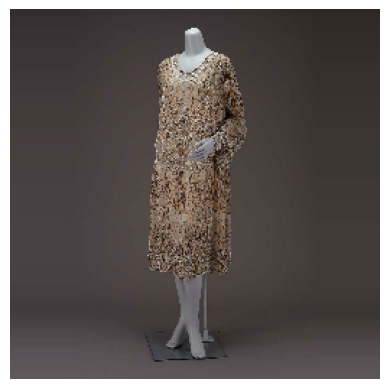

In [13]:
# display one image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## DISCRIMINATOR

In [71]:
discriminator = keras.Sequential(
    [   
        # use maxpool instead of conv2d at the first two downsize

        keras.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(32, kernel_size=3, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(32, kernel_size=3, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPool2D(pool_size=(2,2), strides=2, padding="same"),

        layers.Conv2D(64, kernel_size=3, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, kernel_size=3, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPool2D(pool_size=(2,2), strides=2, padding="same"),

        layers.Conv2D(128, kernel_size=3, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPool2D(pool_size=(2,2), strides=2, padding="same"),

        layers.Conv2D(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1024, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu_156 (LeakyReLU)  (None, 256, 256, 32)     0         
                                                                 
 conv2d_129 (Conv2D)         (None, 256, 256, 32)      9248      
                                                                 
 leaky_re_lu_157 (LeakyReLU)  (None, 256, 256, 32)     0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_130 (Conv2D)         (None, 128, 128, 64)      18496     
                                                     

## GENERATOR

In [72]:
latent_dim = 1024

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(generator_input * generator_input * 1024),
        layers.Reshape((generator_input, generator_input, 1024)),
        layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),


        layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 4096)              4198400   
                                                                 
 reshape_5 (Reshape)         (None, 2, 2, 1024)        0         
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 4, 4, 512)        4719104   
 Transpose)                                                      
                                                                 
 leaky_re_lu_166 (LeakyReLU)  (None, 4, 4, 512)        0         
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 8, 8, 512)        2359808   
 Transpose)                                                      
                                                                 
 leaky_re_lu_167 (LeakyReLU)  (None, 8, 8, 512)        0 

## GAN

In [73]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## GAN monitor

In [74]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=1024):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"{folder}generated_img_%03d_%d.png" % (epoch, i))

In [75]:
# save the best model based on the validation KID metric
checkpoint_path = folder + "gan_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="g_loss",
    mode="min",
    save_best_only=True,
)

## FIT

In [80]:
learning_rate = 0.00003

In [81]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [82]:
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [11]:
# gan.load_weights(filepath=f'{folder}GAN_maxpool_9000_7_100ep')

In [83]:
epochs = 50  # In practice, use ~80 epochs

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim), checkpoint_callback]
)

Epoch 1/50
317/317 [==============================] - 135s 417ms/step - d_loss: 0.1746 - g_loss: 3.5275
Epoch 2/50
317/317 [==============================] - 135s 425ms/step - d_loss: 0.1532 - g_loss: 3.8746
Epoch 3/50
317/317 [==============================] - 137s 429ms/step - d_loss: 0.1192 - g_loss: 5.7657
Epoch 4/50
317/317 [==============================] - 137s 429ms/step - d_loss: 0.0551 - g_loss: 10.4872
Epoch 5/50
317/317 [==============================] - 137s 430ms/step - d_loss: 0.0910 - g_loss: 9.0936
Epoch 6/50
317/317 [==============================] - 137s 430ms/step - d_loss: 0.0582 - g_loss: 6.7523
Epoch 7/50
317/317 [==============================] - 137s 431ms/step - d_loss: 0.2078 - g_loss: 4.6884
Epoch 8/50
317/317 [==============================] - 138s 432ms/step - d_loss: 0.1531 - g_loss: 4.3826
Epoch 9/50
317/317 [==============================] - 137s 429ms/step - d_loss: 0.1424 - g_loss: 5.4046
Epoch 10/50
317/317 [==============================] - 137s 429

## plot and save

In [84]:
# # uncomment to initiate a dataframe to hold dloss and gloss
dg_df = pd.DataFrame(columns=['d_loss','g_loss'])
# dg_df = pd.read_csv(f'{folder}dgloss1.csv')

In [ ]:
dg_df.iloc[:101]

In [85]:
d_loss = gan.history.history['d_loss']
g_loss = gan.history.history['g_loss']
epch = range(1,len(d_loss)+1)

In [86]:
dg_list = list(zip(d_loss,g_loss))
dg_df_new = pd.DataFrame(dg_list,columns=['d_loss','g_loss'])
dg_df = pd.concat([dg_df,dg_df_new],axis=0)

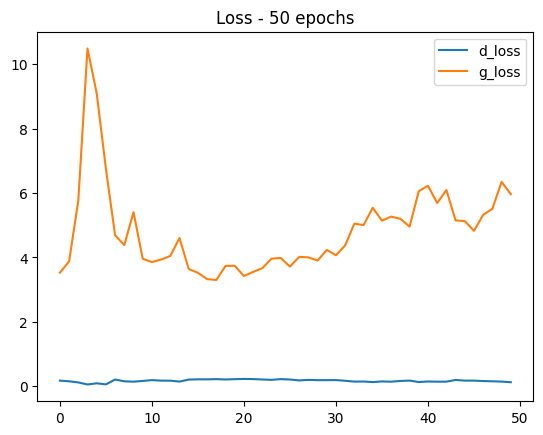

In [87]:
dg_df.reset_index(drop=True).plot()
plt.title(f"Loss - {dg_df.shape[0]} epochs")
plt.legend();

In [76]:
dg_df.to_csv(f'{folder}dgloss.csv',index=False)

In [77]:
gan.save_weights(filepath=f'{folder}GAN_maxpool_9000_7_200ep')

## generate

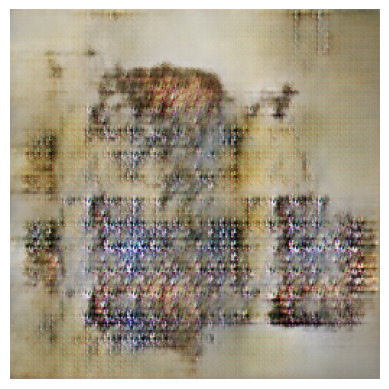

In [110]:
random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
generated_images = gan.generator(random_latent_vectors)
generated_images *= 255
generated_images.numpy()
for i in range(1):
    img = keras.preprocessing.image.array_to_img(generated_images[i])
    plt.imshow(img)
    plt.axis("off")